# Train RPN Network to segment


In [17]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import segmentation_models_pytorch as smp
import albumentations as A

In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Load image
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Load mask

        # Convert to NumPy array
        image = np.array(image)
        mask = np.array(mask)

        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply histogram equalization
        image = cv2.equalizeHist((image * 255).astype(np.uint8)) / 255.0

        # Resize the image and mask to (224, 224)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)

        # Optionally apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert image and mask to PyTorch tensors
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask

In [19]:
# Define the transformation using albumentations
transform = A.Compose(
    [
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(p=0.5),
        A.Affine(),
    ]
)

In [20]:
image_dir = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/preprocessed_All247masks/preprocessed_xray"
mask_dir = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/images/All247imagesPNG/masks"

# Get list of image and mask files
image_paths = sorted(
    [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
)
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Split data into train, validation, and test sets into 0.8, 0.1, 0.1
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = (
    train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_mask_paths, test_size=0.5, random_state=42
)

# Create dataset
train_heart_dataset = CustomDataset(
    train_image_paths, train_mask_paths, transform=transform
)
val_heart_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=None)
test_heart_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=None)

# Create dataloader
train_dataloader = DataLoader(train_heart_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_heart_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_heart_dataset, batch_size=16, shuffle=False)

In [21]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([16, 1, 224, 224]), torch.Size([16, 1, 224, 224]))

In [22]:
np.unique(image)

array([0.00000000e+00, 2.46833352e-07, 1.09339999e-06, ...,
       9.99933938e-01, 9.99947103e-01, 1.00000000e+00])

In [23]:
np.unique(mask)

array([0, 1, 2, 3], dtype=uint8)

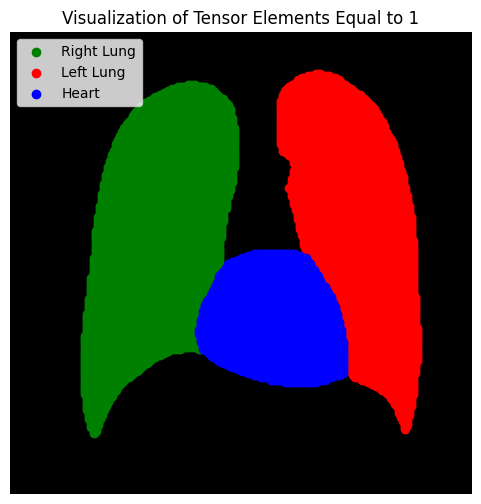

In [27]:
right_lung = np.column_stack(np.where(mask[0, 0] == 1))
left_lung = np.column_stack(np.where(mask[0, 0] == 2))
heart = np.column_stack(np.where(mask[0, 0] == 3))

plt.figure(figsize=(6, 6))
plt.axis(False)
plt.imshow(mask[0, 0], cmap="gray", interpolation="none")
plt.scatter(
    right_lung[:, 1], right_lung[:, 0], color="green", marker="o", label="Right Lung"
)
plt.scatter(
    left_lung[:, 1], left_lung[:, 0], color="red", marker="o", label="Left Lung"
)
plt.scatter(heart[:, 1], heart[:, 0], color="blue", marker="o", label="Heart")
plt.legend()
plt.title("Visualization of Tensor Elements Equal to 1")
plt.show()

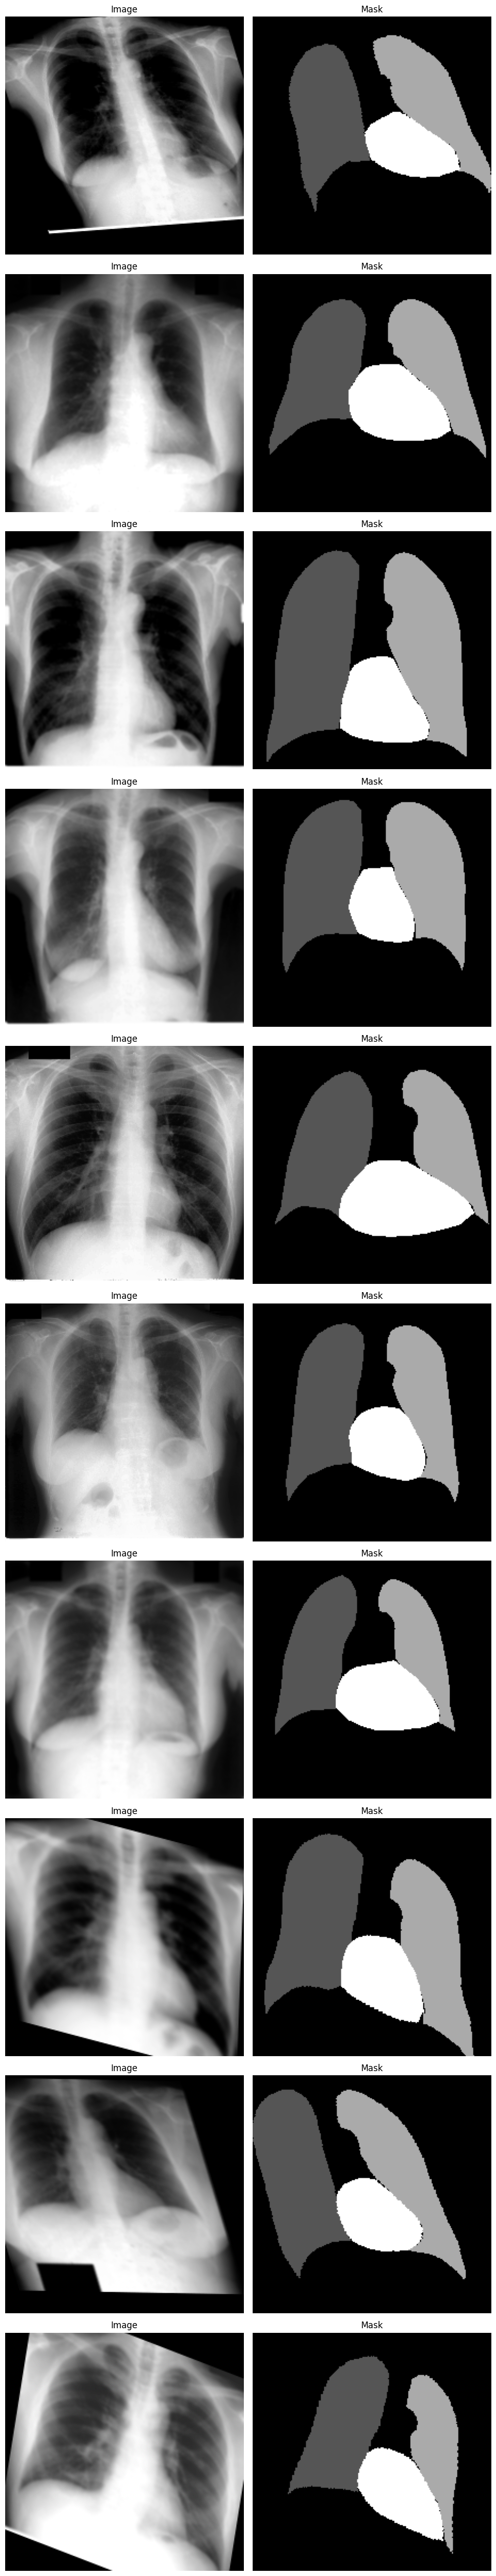

In [16]:
def visualize_sample(images, masks, n_samples=4):
    """
    Function to visualize a batch of images and masks.

    Parameters:
    images (torch.Tensor): Batch of images.
    masks (torch.Tensor): Batch of masks.
    n_samples (int): Number of samples to visualize.
    """
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples * 5))
    for i in range(n_samples):
        img = images[i].numpy()  # Convert from (C, H, W) to (H, W, C)
        mask = masks[i].numpy()  # Convert from (C, H, W) to (H, W, C)

        axes[i, 0].imshow(img.squeeze(), cmap="gray")  # Display the image
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask.squeeze(), cmap="gray")  # Display the mask
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


# Use the DataLoader to load a batch of images and masks
images, masks = next(iter(train_dataloader))

# Visualize the first few samples
visualize_sample(images, masks, n_samples=10)

# Model Initialization


In [10]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation="sigmoid",
)

In [11]:
preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet50", "imagenet")

In [14]:
from segmentation_models_pytorch import utils

criterion = utils.losses.DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

In [15]:
TRAINING = True

EPOCHS = 150

device = "cuda" if torch.cuda.is_available() else "cpu"

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, loss=criterion, metrics=metrics, device=device, verbose=True
)

## Training


In [17]:
# if TRAINING:

#   best_iou_score = 0.0
#   train_logs_list, valid_logs_list = [], []

#   for i in range(0, EPOCHS):

#     # Perform training and validation
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_dataloader)
#     valid_logs = valid_epoch.run(val_dataloader)
#     train_logs_list.append(train_logs)
#     valid_logs_list.append(valid_logs)

#     # Save model if a better val IoU score is obtained
#     if best_iou_score < valid_logs['iou_score']:
#         best_iou_score = valid_logs['iou_score']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')

In [16]:
img, mask = next(iter(test_dataloader))
img.shape, mask.shape

(torch.Size([16, 1, 224, 224]), torch.Size([16, 1, 224, 224]))

In [151]:
best_model = torch.load("./UNet_Full.pth", map_location=device)
print("Loaded UNet model from this run.")
criterion = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
criterion.__name__ = "DiceLoss"


test_epoch = smp.utils.train.ValidEpoch(
    best_model,
    loss=criterion,
    metrics=metrics,
    device=device,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31072\1001146722.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("./UNet_Full.pth", map_location=dev

Loaded UNet model from this run.
valid: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, DiceLoss - 0.1879, iou_score - 0.7124]


# Binary Inference


In [1]:
from scipy.ndimage import binary_opening, binary_fill_holes, label, binary_dilation
from skimage.morphology import disk


def postprocess_mask(mask):
    # Ensure the mask is a 2D numpy array
    if len(mask.shape) == 3 and mask.shape[0] == 1:
        mask = mask[0]
    elif len(mask.shape) == 3 and mask.shape[2] == 1:
        mask = mask[:, :, 0]
    elif len(mask.shape) != 2:
        raise ValueError("Expected a 2D mask but got shape {}".format(mask.shape))

    # Convert mask to binary (0 or 1)
    binary_mask = mask > 0.5

    # Apply binary opening with a disk structuring element of radius 5
    structuring_element = disk(5)
    opened_mask = binary_opening(binary_mask, structure=structuring_element)

    # Label the connected components
    labeled_mask, num_features = label(opened_mask)

    # Find the largest connected component
    sizes = np.bincount(labeled_mask.ravel())
    if len(sizes) > 1:
        max_label = sizes[1:].argmax() + 1
        largest_segment = (labeled_mask == max_label).astype(np.uint8)

        # Fill holes in the largest connected component
        filled_mask = binary_fill_holes(largest_segment)

        # Apply binary dilation with the same structuring element
        final_mask = binary_dilation(filled_mask, structure=structuring_element)

        return final_mask


def test_model(model, test_loader, device):
    model.eval()
    predicted_masks = []
    original_images = []
    original_masks = []
    with torch.inference_mode():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            # Assuming the output is of shape (batch_size, channels, height, width)
            # Taking the first channel
            predicted_masks_batch = (outputs[:, 0, :, :] > 0.5).cpu().numpy()
            original_images.extend(images.cpu())
            original_masks.extend(masks.cpu())
            for mask in predicted_masks_batch:
                postprocessed_mask = postprocess_mask(mask)
                predicted_masks.append(postprocessed_mask)
    return original_images, original_masks, predicted_masks


def visualize_predictions(images, original_masks, predicted_masks, k=5):
    for i in range(min(k, len(images))):
        plt.figure(figsize=(15, 5))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy(), cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        # Display original mask
        plt.subplot(1, 3, 2)
        plt.imshow(original_masks[i].permute(1, 2, 0).numpy(), cmap="gray")

        plt.title("Original Mask")
        plt.axis("off")

        # Display predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i], cmap="gray")

        plt.title(f"Predicted Mask Shape {predicted_masks[i].shape}")

        plt.axis("off")

        plt.show()

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31072\935560340.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("./UNet_Heart_Final.pth", map_locati

Loaded UNet model from this run.


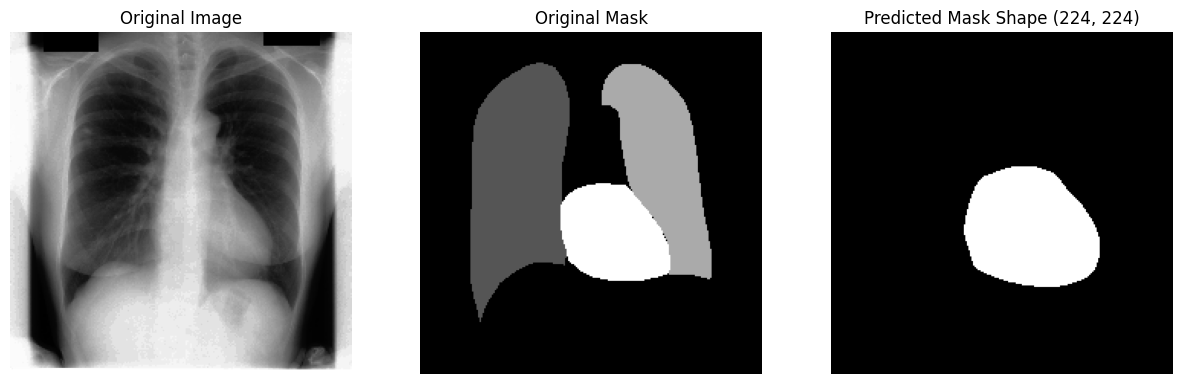

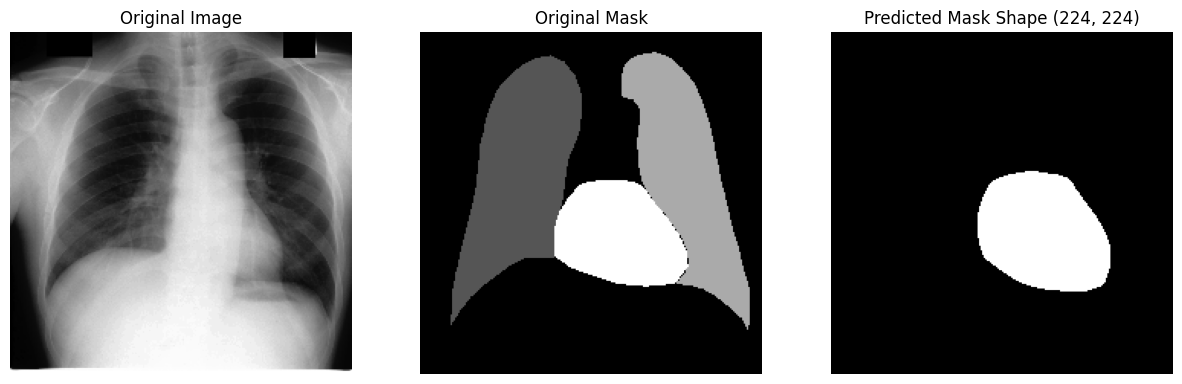

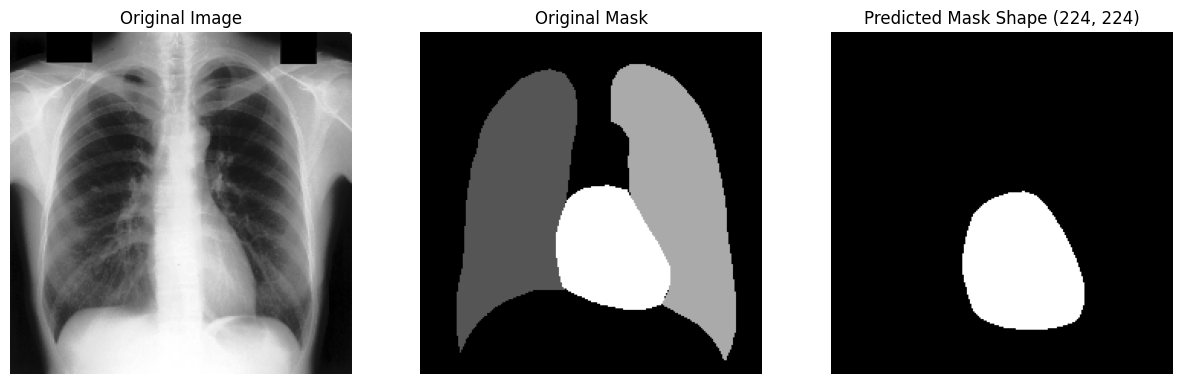

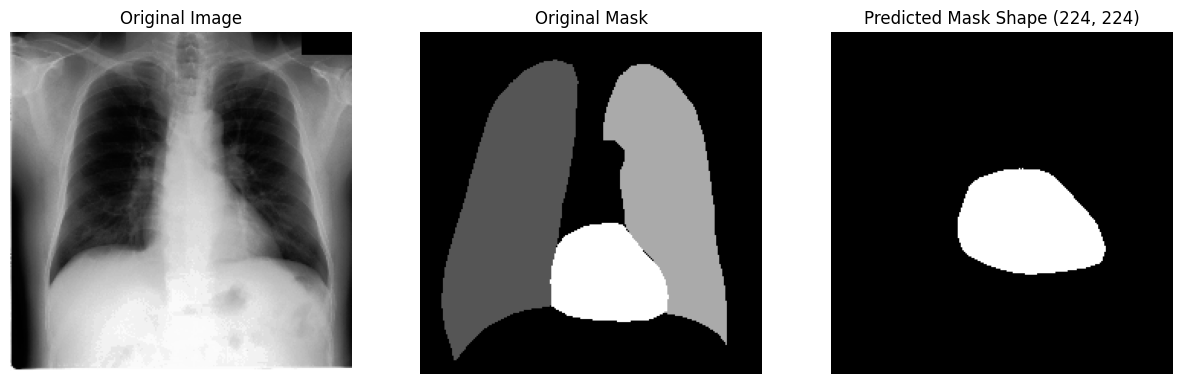

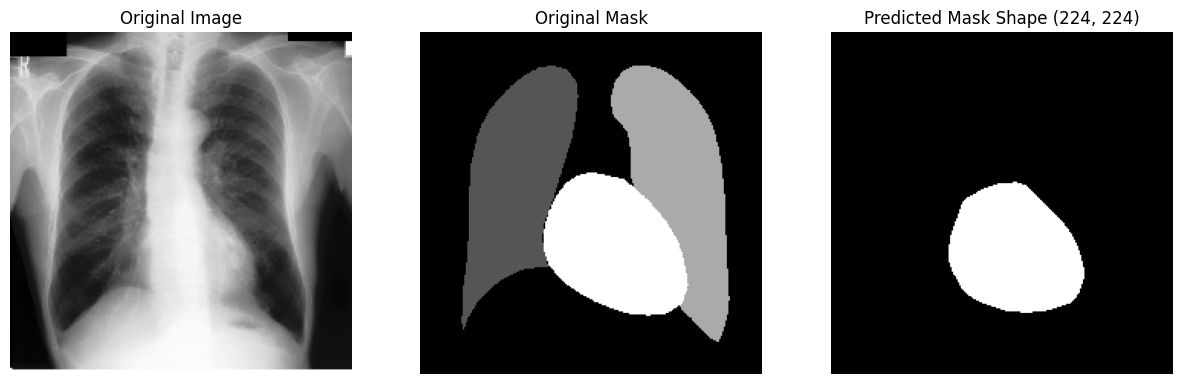

In [153]:
device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = torch.load("./UNet_Heart_Final.pth", map_location=device)
print("Loaded UNet model from this run.")

original_images, original_masks, predicted_masks = test_model(
    best_model, test_dataloader, device
)
visualize_predictions(original_images, original_masks, predicted_masks, k=5)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31072\3872619529.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("./UNet_Lung.pth", map_location=dev

Loaded UNet model from this run.


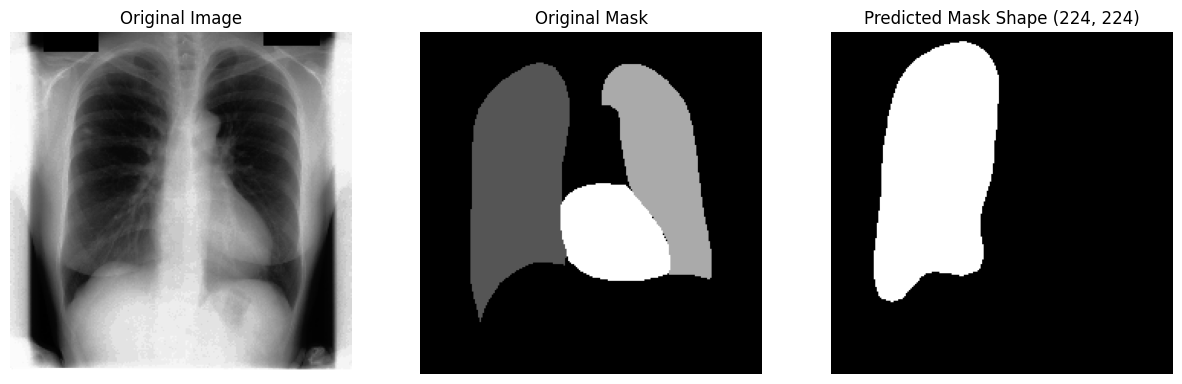

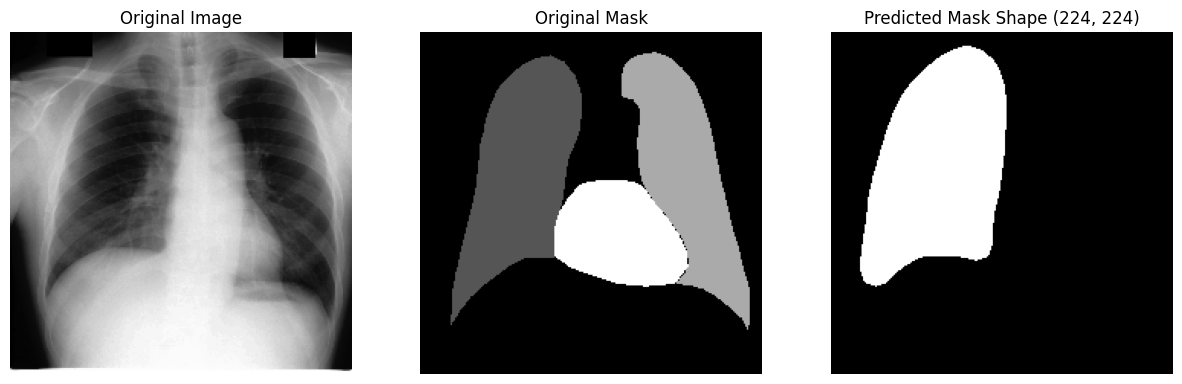

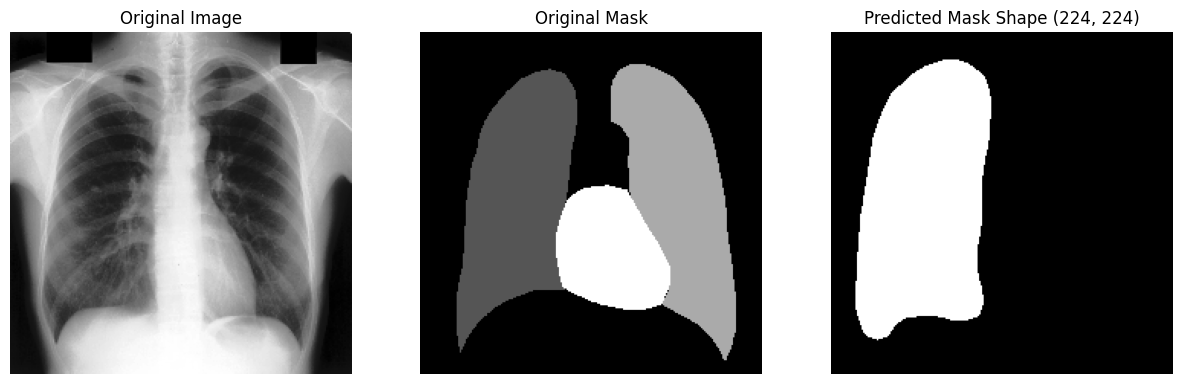

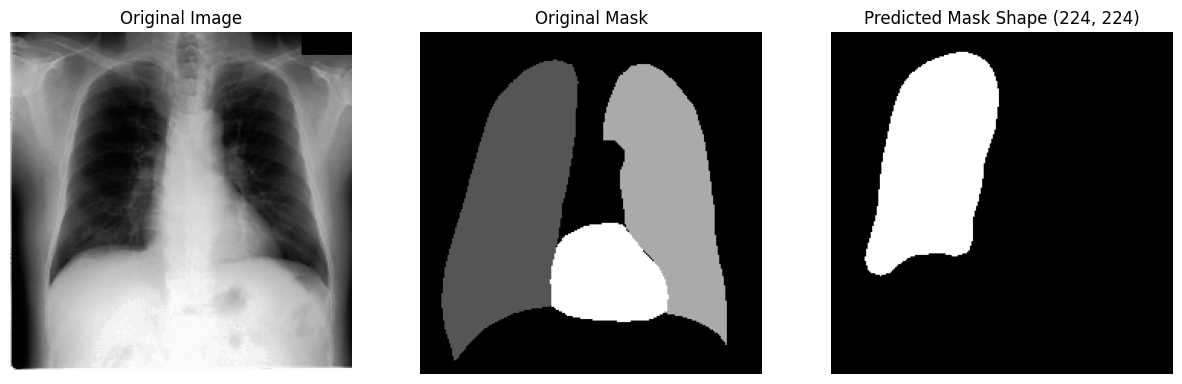

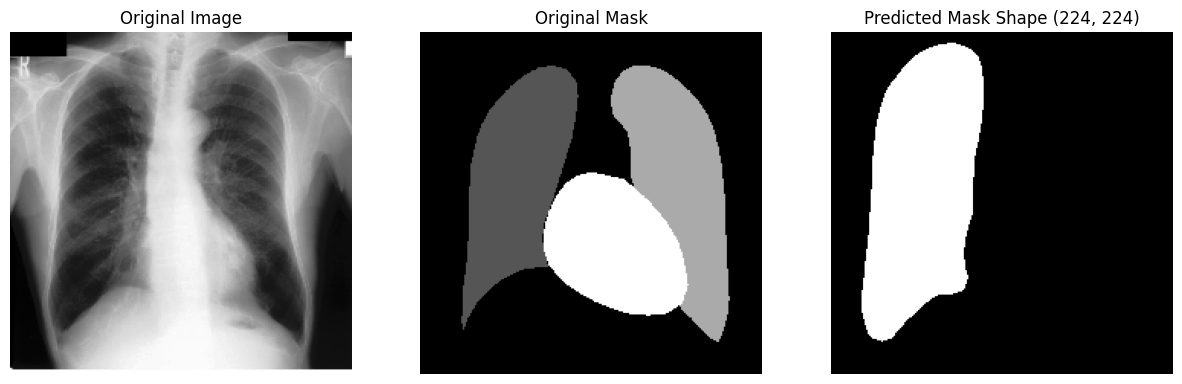

In [155]:
device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = torch.load("./UNet_Lung.pth", map_location=device)
print("Loaded UNet model from this run.")

original_images, original_masks, predicted_masks = test_model(
    best_model, test_dataloader, device
)
visualize_predictions(original_images, original_masks, predicted_masks, k=5)

# Multiclass Inference


In [175]:
import matplotlib.pyplot as plt
import numpy as np


def postprocess_mask_multi(mask, num_classes):
    processed_masks = []

    for i in range(num_classes):
        class_mask = (mask == i).astype(np.uint8)  # Extract the mask for class 'i'

        # Apply binary opening with a disk structuring element of radius 5
        structuring_element = disk(5)
        opened_mask = binary_opening(class_mask, structure=structuring_element)

        # Label the connected components
        labeled_mask, num_features = label(opened_mask)

        # Find the largest connected component
        sizes = np.bincount(labeled_mask.ravel())
        if len(sizes) > 1:
            max_label = sizes[1:].argmax() + 1
            largest_segment = (labeled_mask == max_label).astype(np.uint8)

            # Fill holes in the largest connected component
            filled_mask = binary_fill_holes(largest_segment)

            # Apply binary dilation with the same structuring element
            final_mask = binary_dilation(filled_mask, structure=structuring_element)

            processed_masks.append(final_mask)
        else:
            processed_masks.append(np.zeros_like(class_mask))

    return np.stack(processed_masks, axis=0)


def test_model(model, test_loader, device, num_classes):
    model.eval()
    predicted_masks = []
    original_images = []
    original_masks = []
    with torch.inference_mode():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            # Assuming the output is of shape (batch_size, num_classes, height, width)
            predicted_masks_batch = (
                outputs.argmax(dim=1).cpu().numpy()
            )  # Take the argmax across classes
            original_images.extend(images.cpu())
            original_masks.extend(masks.cpu())
            for mask in predicted_masks_batch:
                postprocessed_mask = postprocess_mask_multi(mask, num_classes)
                predicted_masks.append(postprocessed_mask)
    return original_images, original_masks, predicted_masks


def visualize_predictions(images, original_masks, predicted_masks, k=5, num_classes=4):
    for i in range(min(k, len(images))):
        fig, axes = plt.subplots(1, num_classes + 1, figsize=(15, 5))

        # Display original image
        axes[0].imshow(images[i].permute(1, 2, 0).numpy(), cmap="gray")
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(original_masks[i][0], cmap="gray")

        axes[1].set_title("Original Mask")
        axes[1].axis("off")

        # Display predicted masks for each class
        for j in range(num_classes - 1):
            axes[j + 2].imshow(predicted_masks[i][j + 1], cmap="gray")
            axes[j + 2].set_title(f"Predicted Mask Class {j+1}")
            axes[j + 2].axis("off")
        plt.show()

C:\Users\DryLab\AppData\Local\Temp\ipykernel_39548\3444528017.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("./UNet_Full.pth", map_location=dev

Loaded UNet model from this run.


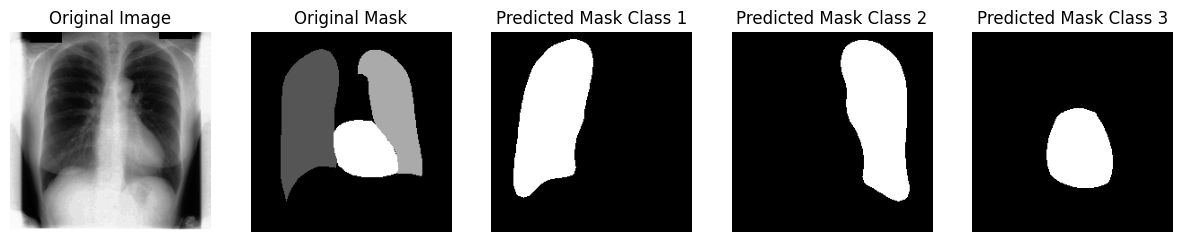

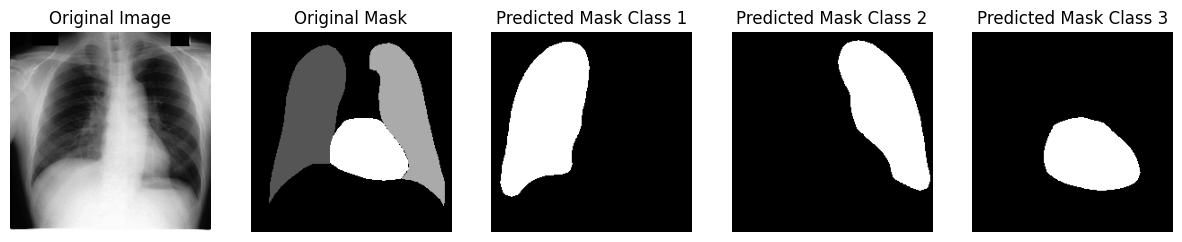

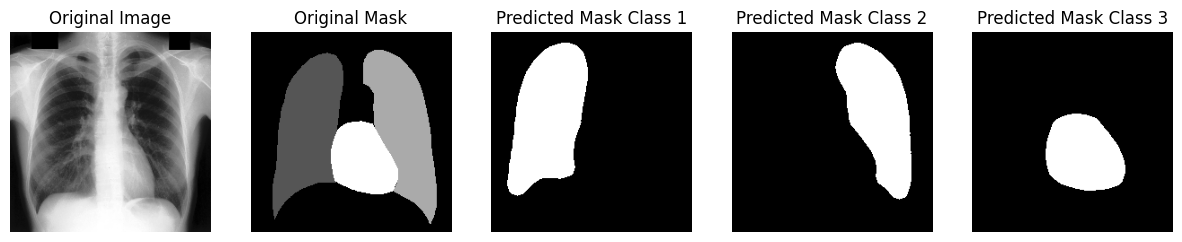

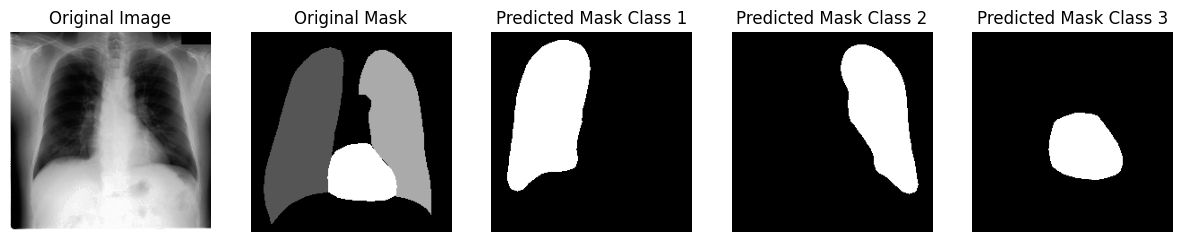

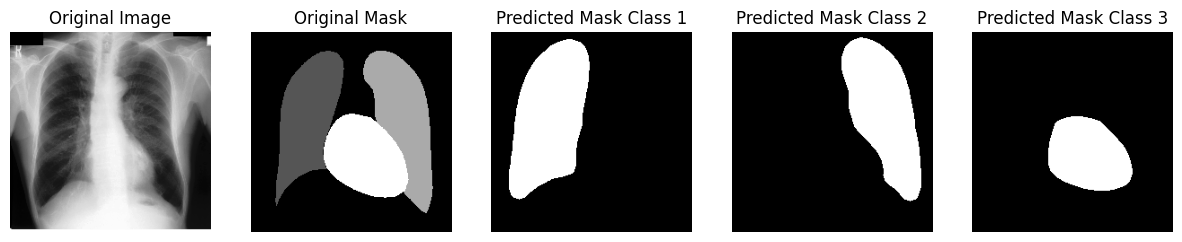

In [178]:
device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = torch.load("./UNet_Full.pth", map_location=device)
print("Loaded UNet model from this run.")

original_images, original_masks, predicted_masks = test_model(
    best_model, test_dataloader, device, num_classes=4
)
visualize_predictions(
    original_images, original_masks, predicted_masks, k=5, num_classes=4
)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lung_model = torch.load("./UNet_Lung.pth", map_location=device)
print("Loaded Lungs UNet model from this run.")

heart_model = torch.load("./UNet_Heart_Final.pth", map_location=device)
print("Loaded Heart UNet model from this run.")

full_model = torch.load("./UNet_Full.pth", map_location=device)
print("Loaded Full UNet model from this run.")

C:\Users\DryLab\AppData\Local\Temp\ipykernel_39768\141638364.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lung_model = torch.load("./UNet_Lung.pth", map_location=devi

Loaded Lungs UNet model from this run.
Loaded Heart UNet model from this run.
Loaded Full UNet model from this run.


In [12]:
def generate_segmentation_mask(model, images):
    model.eval()
    with torch.inference_mode():
        images = images.to(device)
        outputs = model(images)
        # Assuming the output is of shape (batch_size, channels, height, width)
        # Taking the first channel
        predicted_masks = (outputs[:, 0, :, :] > 0.5).cpu().numpy()
    return predicted_masks


# Example image tensor (1, 1, 224, 224)
image = Image.open(
    "C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/NLMCXR_png/CXR5_IM-2117-1003002.png"
).convert("L")
image = image.resize((224, 224), Image.NEAREST)
image = np.array(image)
image = image.astype(np.float32) / 255.0  # Normalize image to [0, 1]
image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device)

lung_mask = generate_segmentation_mask(lung_model, image)
heart_mask = generate_segmentation_mask(heart_model, image)

In [13]:
combined_mask = lung_mask | heart_mask

(-0.5, 223.5, 223.5, -0.5)

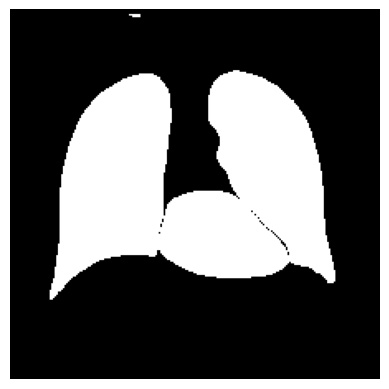

In [14]:
plt.imshow(combined_mask.squeeze(), cmap="gray")
plt.axis(False)

In [15]:
def generate_segmentation_mask(model, images):
    model.eval()
    with torch.inference_mode():
        images = images.to(device)
        outputs = model(images)
        # Assuming the output is of shape (batch_size, channels, height, width)
        # Taking the first channel
        predicted_masks = outputs.argmax(dim=1).cpu().numpy()
    return predicted_masks


full_mask = generate_segmentation_mask(full_model, image)

(-0.5, 223.5, 223.5, -0.5)

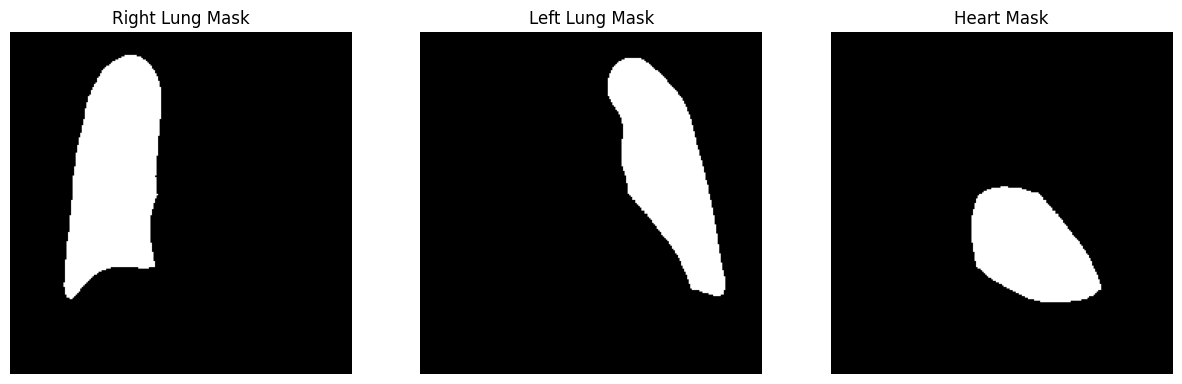

In [16]:
# Assume 'segmentation_output' is the output from your UNet model
# and has the shape (H, W) where each pixel value is the class label
# 0: background, 1: right lung, 2: left lung, 3: heart

# Get binary masks for each region
right_lung_mask = torch.from_numpy(full_mask) == 1
left_lung_mask = torch.from_numpy(full_mask) == 2
heart_mask = torch.from_numpy(full_mask) == 3

# Plotting the masks
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Right Lung Mask")
plt.imshow(right_lung_mask.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Left Lung Mask")
plt.imshow(left_lung_mask.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Heart Mask")
plt.imshow(heart_mask.squeeze(), cmap="gray")
plt.axis("off")


(-0.5, 223.5, 223.5, -0.5)

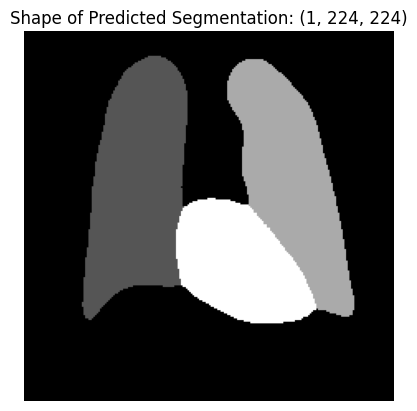

In [17]:
plt.imshow(full_mask.squeeze(), cmap="gray")
plt.title(f"Shape of Predicted Segmentation: {full_mask.shape}")
plt.axis(False)